#모델 inference

In [ ]:
%cd /content/drive/MyDrive/darknet

In [ ]:
from darknet import *

In [ ]:
# test 전용 cfg 내용으로 변경
%cd /content/drive/MyDrive/darknet/cfg
!sed -i 's/batch=64/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-custom.cfg
%cd ..

In [ ]:
# darknet.py 컴파일
!make

### 학습된 weight로 모델 불러오기

In [ ]:
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/mask_data.data", "/content/drive/MyDrive/darknet/backup/yolov4-custom_best.weights")

###object detection전 전처리

In [ ]:
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width 
  height_ratio = img_height/height 

  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

###Test
테스트할 이미지 업로드

In [ ]:
from google.colab import files
files.upload()

불러온 이미지 확인

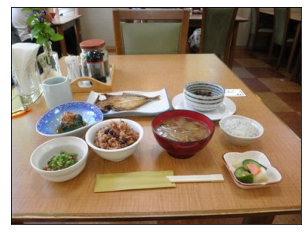

In [ ]:
image = cv2.imread('/content/drive/MyDrive/darknet/13273.jpg')
imagee = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(imagee) 
plt.xticks([]) 
plt.yticks([]) 
plt.show() 

이미지 detection한 바운딩 박스 정보 출력

In [ ]:
detections, width_ratio, height_ratio = darknet_helper(imagee, width, height)
detections

[('rice',
  '74.37',
  (330.8217468261719,
   233.03665161132812,
   55.115665435791016,
   49.32010269165039)),
 ('miso soup',
  '82.0',
  (246.83096313476562,
   236.90647888183594,
   87.82862091064453,
   78.36955261230469))]

칼로리 표시하기

In [ ]:
import pandas as pd
# 칼로리가 포함된 txt파일 불러오기
data = pd.read_csv('/content/drive/MyDrive/category (1).txt',sep=',')
temp = data['name'].str.split('(')
temp

0                        [1\trice , 310kcal]
1                [2\teels on rice , 717kcal]
2                       [3\tpilaf , 625kcal]
3     [4\tchicken-'n'-egg on rice , 647kcal]
4         [5\tpork cutlet on rice , 650kcal]
                       ...                  
95           [96\tdipping noodles , 206kcal]
96                 [97\thot dog , 289.7kcal]
97            [98\tfrench fries , 311.0kcal]
98                [99\tmixed rice , 216kcal]
99     [100\tgoya chanpuru , 272kcal. 227g)]
Name: name, Length: 100, dtype: object

In [ ]:
kcal_list = {}
# 음식이름과 칼로리 dict형식으로 매칭시켜놓기
for t in temp:
  if len(t)==2:
    index = t[0].split('\t')[1].strip(' ')
    kcal_list[index] = t[1]

kcal_list

{'Japanese tofu and vegetable chowder': '88kcal',
 'Japanese-style pancake': '490kcal',
 'beef bowl': '616kcal',
 'beef curry': '653kcal',
 'bibimbap': '703kcal',
 'boiled chicken and vegetables': '158kcal',
 'chicken rice': '350kcal',
 "chicken-'n'-egg on rice": '647kcal',
 'chilled noodle': '27kcal',
 'chinese soup': '77kcal',
 'croissant': '227kcal',
 'croquette': '358kcal',
 'cutlet curry': '158kcal',
 'dipping noodles': '206kcal',
 'eels on rice': '717kcal',
 'egg roll': '130kcal',
 'fish-shaped pancake with bean jam': '265kcal',
 'french fries': '311.0kcal',
 'fried rice': '250kcal',
 'fried shrimp': '287kcal',
 'goya chanpuru': '272kcal. 227g)',
 'gratin': '131kca',
 'green salad': '17kcal',
 'grilled eggplant': '108kcal',
 'grilled salmon': '99kcal',
 'hamburger': '270kcal',
 'hot dog': '289.7kcal',
 'jiaozi': '280kcal',
 'kinpira-style sauteed burdock': '135kcal',
 'macaroni salad': '290kacl',
 'miso soup': '84kcal',
 'mixed rice': '216kcal',
 'oden': '135kcal',
 'omelet': '15

In [ ]:
food_list = detections
# 감지된 음식 이름에 해당하는 kcal 표시하기
for food in food_list:
  print(kcal_list[food[0]])

310kcal
84kcal


사진에 bounding box + kcal 표시

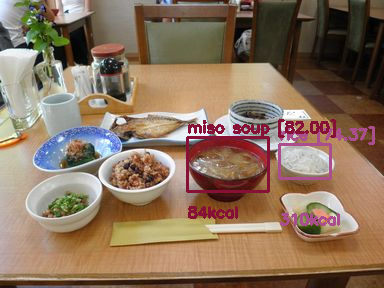

총 칼로리 : 394


In [ ]:
kcal_sum = 0
for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(imagee, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(imagee, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
  cv2.putText(imagee,kcal_list[label],
              (left, top+80), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
              class_colors[label], 2)
  kcal_sum+=int(kcal_list[label].strip('kcal'))
image = cv2.cvtColor(imagee, cv2.COLOR_RGB2BGR)
cv2_imshow(image)
print(f"총 칼로리 : {kcal_sum}")